Note: references to code in the repo are not yet set, but should be obvious from the text.
Anyway, a look at the code is always beneficial.

# Overall idea behind COMBINE

Finding bedrock geometry from surface information of glaciers is not straightforward. The ice flow and therefore surface is determined by bed rock and mass balance together with glacier dynamics. This is what a usual forward model does: take bed rock and mass balance and run ice dynamics forward in time to obtain ice thickness/surface height. To go the other way around, we would need a backward model, which is hard to find (unknown in most cases to my knowledge) due to the complexity of ice dynamics.

So what to do? Mass balance may be estimated from climate data with appropriate parametrizations and is assumed to be known.

So a simplified forward model giving a surface $s$ (after time $t$) based on bedrock $b$ would be:
$$s(b, t)$$

So if we now the surface height at time $t_0$ (I referred to it in the model as the moment after spinup) and later on at $t_1$ we can run the forward model from a first - known - state $$s_0 = s(b, t_0)$$ forward to a later state $$s_1 = s(b, t_1)$$ with an estimated bedrock $b$. Assume we know the true surface at $t_1$, $$s_{1, true} = s(b_{true}, t_1)$$. Then we try to estimate $b$ in a way, that $$s(b, t_1) = s(b_{true}, t_1)$$, so the forward run is giving us the observed surface. To find this proper bed estimate, we need a first guess, what it could look like and then iteratively improve our guess. As a measure for the quality of the guess we define a cost function, e.g. $$J(b) = \int_{domain}(s(b, t_1) - s_{true})^2$$, which can be minimized by optimizing $b$.

As easy as this sounds, there is one major caveat: the inversion is ill-posed, meaning, that there are (most probably) multiple possible suitable bedrock estimates. And also the high dimensionality of $b$ together with the complex ice dynamics make it harder for the optimization algorithm. A good first guess close to the actual solution is already a big help.

We can support the optimization further by adding additional knowledge (e.g. bed measurements of known points, but also assumptions of not too big steps in bedrock and knowledge of the actual) and penalizing solutions, that contradict this knowledge. To implement this, regularization terms $J_{reg, i}$ can be added to the cost function and therefore will be considered during optimization:
$$J(b) = \int_{domain}(s(b, t_1) - s_{true})^2 + \alpha_i J_{reg, i}$$

$\alpha_i$ are the regularization parameters (reg_parameters in code), simple factors, that scale the importance of these regularizations. As a general rule, they may be corresponding to the inverse of the variance of a quantity described by a regularization, but I for my part fine tuned them during my thesis. Feel free to play around with them a bit and get some insights in their behaviour/influence. In my opinion, proper choice of regularizations is half the deal.

# Implementation details - why PyTorch?
The dynamics model was originally working on numpy arrays. However, for efficient optimization, a Jacobian of the cost function would be desirable (telling the optimization algorithm, in which way to improve the estimated bed). As it is cumbersome and also not that flexible to changes in code, the derivation is not done by hand. Instead, we exploit the capabilities of PyTorch, originally a deep learning framework. There, Tensors are used instead of numpy arrays. They can more or less be used directly as substitutes, but do have the major advantage of tracing the calculations. This means throughout the forward model run until the cost function calculation, all steps are stored (memory consumption!!) and from the derivative of every single atomar computation step, the adjoint is derived. This is used as a Jacobian for optimization.

# Example for COMBINE2D

## Get to work

In [ ]:
# Add local repository to python path -> allows for importing here
import sys
sys.path.append(##FIXME##'/COMBINE')

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import salem
import glob
import os

In [2]:
import oggm.cfg
oggm.cfg.initialize()

2021-05-25 15:05:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-05-25 15:05:32: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-05-25 15:05:32: oggm.cfg: Multiprocessing: using all available processors (N=4)
2021-05-25 15:05:33: oggm.utils: Checking the download verification file checksum...


There are already some test_cases defined in the corresponding python file. These include information on position (lat, lon, ...) for retrieval of DEM, but also information on mass balance (ela height, mb_gradient).

Here, I chose one volcano, on which we will create an ice cap

In [3]:
from combine2d.core.test_cases import Giluwe
case = Giluwe

The information contained in the test_case definition needs to be converted to 2D bed information now. We create a glacier directory for this test case.

In [4]:
from combine2d.core.utils import NonRGIGlacierDirectory
glacier_dir_path = '/home/patrick/UNI/Master/github/COMBINE/' ##FIXME## ''
gdir = NonRGIGlacierDirectory(Giluwe, glacier_dir_path)

For the inversion, a couple of additional settings is required:
- the creation of the glacier needs a time, for which the spin-up is run (yrs_spinup) with an eventually extra specified mass balance (mb_spinup)
- after the base state of the glacier is reached (assume e.g. this is then 1960, from which we do know first surface measurement data = model state), the glacier model will be run forward with an estimated bed for another couple years (specified by yrs_forward_run), where another measurement is known. In the end the whole inversion boils down to optimizing the estimated glacier bed in a way, that the glacier model runs with a surface from the spin-up state for further yrs_forward_run and reaches the surface state known after this time.
- some options are for minimization and may be solver dependent (see scipy documentation)
- fg_... options are for the creation of the first guessed bed, a first estimate of the bed, from which the model will be run forward, then the estimate is adapted/improved, the model is run again, ... until a state with a surface is reached, which resembles the known surface state. The better the first guess is, the faster and more accurate is the optimized estimate. It also helps to cope with ill-posedness and reduces the need for regularization. The closer we start to the optimum, the less likely we run into another local minimum or even diverge.
- bounds_min_max gives additional restriction of estimated ice thicknesses to avoid overdeepenings (the solver sometimes tends to make single bedrock cells very deep, which are then filled with ice during forward runs. This is not only unlikely, but also causing numerical issues, as large steps in bedrock are problematic with mass conservation and also necessitate small time steps in the numerical model, making it slow and drastically increasing memory consumption, eventually crashing the whole machine. This will also be adressed by regularization.)
- reg_parameters: one of the most important ingredients for successfull inversion. Discussed on its own.

In [5]:
from copy import deepcopy
default_minimize_options = {
    'maxiter': 50,  # 1000,
    'ftol': 1e-7, 'gtol': 1e-8,
    'disp': True, 'maxcor': 100, 'maxls': 50
}

In [6]:
default_Giluwe_inversion_settings = {
    'mb_spinup': None,
    'yrs_spinup': 2000,
    'yrs_forward_run': 200,
    'reg_parameters': np.array([0.2, 1.25, 1e3, 1e6, 0, 0]),
    'solver': 'L-BFGS-B',
    'minimize_options': deepcopy(default_minimize_options),
    'inversion_subdir': 'first_steps',
    'fg_shape_factor': 1,
    'fg_slope_cutoff_angle': 5,
    'fg_interp_boundary': False,
    'bounds_min_max': (None, 600)
}
gdir.write_inversion_settings(**default_Giluwe_inversion_settings)

## Create glacier

In [7]:
from combine2d.core import gis
from combine2d.core.dynamics import create_glacier
gis.define_nonrgi_glacier_region(gdir)  # create DEM
create_glacier(gdir)  # forward run 2D dynamics model on bedrock defined by DEM for specified time

# Note, that this has to be done only once, afterwards the created glacier is stored in the gdir

We can have a look at the created glacier:

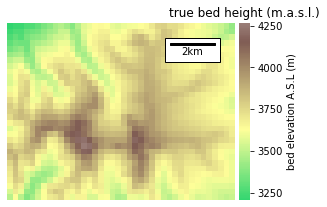

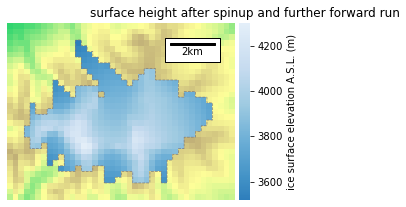

not in equilibrium! consider also plotting spinup


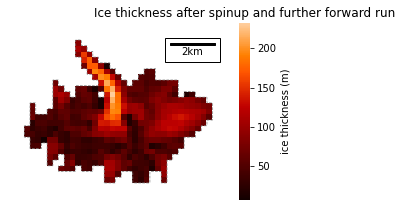

In [8]:
from combine2d.core.visualization import MidpointNormalize, truncate_colormap, \
    imshow_ic, plot_glacier_contours, add_colorbar, get_axes_coords

figsize = (4.5, 3)
spinup_surf = salem.GeoTiff(gdir.get_filepath('spinup_dem')).get_vardata()
reference_surf = salem.GeoTiff(gdir.get_filepath('ref_dem')).get_vardata()
bed_2d = salem.GeoTiff(gdir.get_filepath('dem')).get_vardata()

ref_ice_mask = np.load(gdir.get_filepath('ref_ice_mask'))
ref_it = np.load(gdir.get_filepath('ref_ice_thickness'))
spinup_it = np.load(gdir.get_filepath('spinup_ice_thickness'))
masked_ice_thick_end = np.ma.masked_array(ref_it,
                                          mask=np.logical_not(ref_ice_mask))
#masked_ice_thick_start = np.ma.masked_array(spinup_it,
#                                            mask=np.logical_not(ref_ice_mask))
masked_reference_surf = np.ma.masked_array(reference_surf,
                                           mask=np.logical_not(ref_ice_mask))

#plt.ioff()

cmap = plt.get_cmap('terrain')
terrain_cmap = truncate_colormap(cmap, 0.3, 0.8)
# ---------------------------------------------------------------
# plot true bed height
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_b = imshow_ic(ax, bed_2d, case, cmap=terrain_cmap, ticks='scalebar')
cbar = add_colorbar(fig, ax, im_b)
cbar.set_label('bed elevation A.S.L (m)')
#plt.title('Bed of case {:s}, dx={:d}m'.format(case.name, case.dx))
#fname = '{:s}_bed.{:s}'.format(case.name, file_extension)
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('true bed height (m.a.s.l.)')
plt.show()

cmap = plt.get_cmap('Blues_r')
cut_gray_cmap = truncate_colormap(cmap, 0.3, 0.9)

fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_b = imshow_ic(ax, bed_2d, case, cmap=terrain_cmap, ticks='scalebar')
#plt.title('Ice surface height, {:s}, dx={:d}m, t={:d}a'.format(
#    case.name, case.dx, y))
im_i = imshow_ic(ax, masked_reference_surf, case, cmap=cut_gray_cmap,
                 ticks='scalebar')
cbar = add_colorbar(fig, ax, im_i)
cbar.set_label('ice surface elevation A.S.L. (m)')
plot_glacier_contours(ax, ref_ice_mask, case, resolution_enhance=10) #, linestyles='solid')
#fname = '{:s}_surf_height.{:s}'.format(case.name, file_extension)
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('surface height after spinup and further forward run')
plt.show()

cmap = plt.get_cmap('gist_heat')
it_cmap = truncate_colormap(cmap, 0.05, 0.9)
if not np.all(np.equal(ref_it, spinup_it)):
    print('not in equilibrium! consider also plotting spinup')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_it = imshow_ic(ax, masked_ice_thick_end, case, cmap=it_cmap, ticks='scalebar')
cbar = add_colorbar(fig, ax, im_it)
cbar.set_label('ice thickness (m)')
#fname = '{:s}_ice_thickness.{:s}'.format(case.name, file_extension)
plot_glacier_contours(ax, ref_ice_mask, case, resolution_enhance=10)
#plt.show()
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('Ice thickness after spinup and further forward run')
plt.show()

## First guess
Now we can think about our first guess. It is created by the function below with the approach described in the referenced paper (basically depending on surface gradients).

Depending on what we want to test/show, we could also add noise to the first guess afterwards, to check stability vs first guess quality.

The first guess is also stored in a file in gdir.

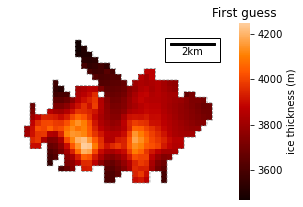

In [9]:
from combine2d.core.first_guess import compile_first_guess
fg_bedrock = compile_first_guess(gdir)


#plot
fg = np.ma.masked_array(fg_bedrock, mask=np.logical_not(ref_ice_mask))
cmap = plt.get_cmap('gist_heat')
it_cmap = truncate_colormap(cmap, 0.05, 0.9)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_it = imshow_ic(ax, fg, case, cmap=it_cmap, ticks='scalebar')
cbar = add_colorbar(fig, ax, im_it)
cbar.set_label('ice thickness (m)')
#fname = '{:s}_ice_thickness.{:s}'.format(case.name, file_extension)
plot_glacier_contours(ax, ref_ice_mask, case, resolution_enhance=10)
#plt.show()
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('First guess')
plt.show()

## Actual Inversion
Now we can start the actual inversion. The function below automatically collects first guess, surface after spinup as a base state to run forward from, surface after run as a target and inversion settings.

In [10]:
# maybe play around with reg_parameters? More detailed insights, whih reg_parameter stands for what in the cost_function.py code
default_Giluwe_inversion_settings['reg_parameters'] = np.array([0.2, 1.25, 1e3, 1e6, 0, 0])
gdir.write_inversion_settings(**default_Giluwe_inversion_settings)

In [11]:
from combine2d.core.inversion import InversionDirectory
idir = InversionDirectory(gdir)  # Use of separate InversionDirectory allows to run multiple inversions from the base of one GlacierDirectory
res = idir.run_minimize()

# note, that #function calls != #iteration


            ----------------------------------------------
            Function Call: 3
            Iteration: 1
            Cost: 238039
            Bed RMSE: 17.6971
            Bed Bias: 3.19285
            Bed Max_diff: 114.873
            Surface RMSE: 15.77
            Surface Max_diff: 116.274
            

            ----------------------------------------------
            Function Call: 4
            Iteration: 2
            Cost: 120225
            Bed RMSE: 15.6369
            Bed Bias: 1.86501
            Bed Max_diff: 122.092
            Surface RMSE: 10.9831
            Surface Max_diff: 89.6973
            

            ----------------------------------------------
            Function Call: 5
            Iteration: 3
            Cost: 80581.2
            Bed RMSE: 14.8704
            Bed Bias: 0.436607
            Bed Max_diff: 129.131
            Surface RMSE: 8.30538
            Surface Max_diff: 78.1333
            

            ---------------------------------


            ----------------------------------------------
            Function Call: 47
            Iteration: 27
            Cost: 32583.5
            Bed RMSE: 11.0393
            Bed Bias: -0.534606
            Bed Max_diff: 126.852
            Surface RMSE: 2.55797
            Surface Max_diff: 32.5024
            

            ----------------------------------------------
            Function Call: 48
            Iteration: 28
            Cost: 32544.5
            Bed RMSE: 10.8192
            Bed Bias: -0.569794
            Bed Max_diff: 125.694
            Surface RMSE: 2.44791
            Surface Max_diff: 31.9265
            

            ----------------------------------------------
            Function Call: 49
            Iteration: 29
            Cost: 32133.6
            Bed RMSE: 10.8275
            Bed Bias: -0.558332
            Bed Max_diff: 125.842
            Surface RMSE: 2.39476
            Surface Max_diff: 31.9219
            

            ------------------

Have a look at the results

/home/patrick/UNI/Master/github/COMBINE/combine2d/core/visualization.py:108: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(arr[::-1, :], cmap=cmap, origin='lower', norm=norm,


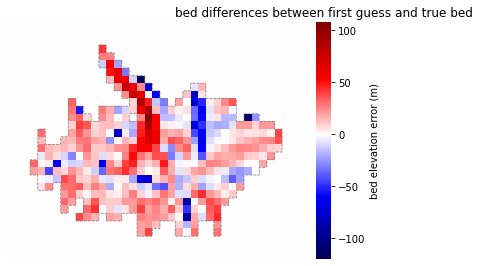

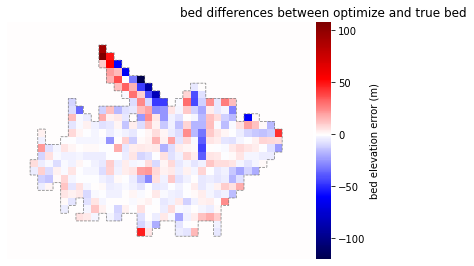

In [12]:
from combine2d.core.visualization import plot_bed_difference, plot_surf_difference
from combine2d.core.data_logging import load_pickle

path = os.path.join(gdir.dir, default_Giluwe_inversion_settings['inversion_subdir'], 'data_logger.pkl')
# Data is stored here, basically all data from each iteration step is stored in there
dl = load_pickle(path)

diff_first_guess = dl.first_guessed_bed - dl.true_bed
diff_optimized = dl.beds[-1] - dl.true_bed
cbar_min = min(diff_first_guess.min(), diff_optimized.min())
cbar_max = max(diff_first_guess.max(), diff_optimized.max())
cbar_min_max = max(abs(cbar_min), abs(cbar_max))
norm = MidpointNormalize(midpoint=0., vmin=-cbar_min_max,
                         vmax=cbar_min_max)
my_cmap = plt.get_cmap('seismic')

fig = plt.figure()
plot_bed_difference(diff_first_guess, None, case,
                    ice_mask=ref_ice_mask,
                    bed_measurements=None,
                    cbar_min=cbar_min, cbar_max=cbar_max,
                    show_cbar=True, norm=norm, cmap=my_cmap,
                    figsize=figsize, existing_fig=fig)
plt.title('bed differences between first guess and true bed')

fig = plt.figure()
plot_bed_difference(diff_optimized, None, case,
                    ice_mask=ref_ice_mask,
                    bed_measurements=None,
                    cbar_min=cbar_min, cbar_max=cbar_max,
                    show_cbar=True, norm=norm, cmap=my_cmap,
                    figsize=figsize, existing_fig=fig)
plt.title('bed differences between optimize and true bed')
plt.show()

The same for the surfaces

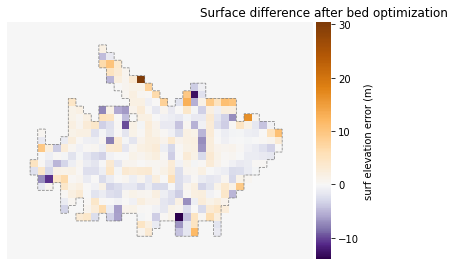

In [13]:
diff_optimized_surf = dl.surfs[-1] - dl.ref_surf
cbar_min = diff_optimized_surf.min()
cbar_max = diff_optimized_surf.max()
my_cmap = plt.get_cmap('PuOr_r')

fig = plt.figure()
plot_surf_difference(diff_optimized_surf, None, case,
                     ice_mask=ref_ice_mask, cbar_min=cbar_min,
                     cbar_max=cbar_max, show_cbar=True,
                     norm=norm, cmap=my_cmap, figsize=figsize, existing_fig=fig)
plt.title('Surface difference after bed optimization')
plt.show()

# Example for COMBINE1D

## Get to work

In [ ]:
# Add local repository to python path -> allows for importing here
import sys
sys.path.append(##FIXME##'/COMBINE')

In [1]:
import numpy as np
import xarray as xr

from combine1d.sandbox.idealized_experiments_optimizer import idealized_inversion_experiment

from oggm import cfg
cfg.initialize()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

2021-05-25 15:51:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-05-25 15:51:45: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-05-25 15:51:45: oggm.cfg: Multiprocessing: using all available processors (N=4)
2021-05-25 15:51:47: oggm.utils: Checking the download verification file checksum...


## Define idealized experiment

COMBINE1D was until now only tested with six idealized topographies. This topografies are defined in combine1d.core.idealized_experiments. Here all possibilies are listed, with three different bed heights, two different widths and three different bed geometries:

In [2]:
all_used_bed_h_geometry = ['linear', 'cliff', 'random']
all_used_along_glacier_geometry = ['constant', 'wide_top']
all_bed_geometry = ['rectangular', 'parabolic', 'trapezoidal']
all_mb_opts = [{'ELA': np.array([3000.]),'grad': np.array([4.])},
               {'ELA': np.array([3000., 3200.]),'grad': np.array([4., 4.])}]
all_glacier_state = ['equilibrium',                    # 0
                     'advancing',                      # 1
                     'retreating',                     # 2
                     'retreating with unknow spinup']  # 3
all_opti_parameter = ['bed_h',               # 0
                      'bed_shape',           # 1
                      'bed_h and bed_shape', # 2
                      'w0',                  # 3
                      'bed_h and w0']        # 4

Note that not all combinations make sense. For example if you choose a 'parabolic' bed geometry you dan not choose a opti_parameter 'w0' or 'bed_h and w0', since w0 is only available for a 'trapezoidal' bed geometry.

In [3]:
# define experiment
experiment = []
experiment.append({'used_bed_h_geometry': all_used_bed_h_geometry[0],
                   'used_along_glacier_geometry': all_used_along_glacier_geometry[0],
                   'bed_geometry': all_bed_geometry[0],
                   # 'mb_opts': all_mb_opts[1],
                   'glacier_state': all_glacier_state[3],
                   'opti_parameter': all_opti_parameter[0],
                   'two_parameter_option': 'implicit', # iterative, explicit, implicit
                   'main_iterations_iterative': 1,
                   'reg_parameters': [1., 1., 1., 10.],
                   'wanted_c_terms': None,
                   'torch_type': 'double',
                   'minimize_options': {'maxiter': 5,
                                        'ftol': 1e-7,
                                        'gtol': 1e-8,
                                        'disp': True,
                                        'maxcor': 50,
                                        'maxls': 50},
                   'max_time_minimize': None,
                   'spinup_yrs': 100,
                   'use_bounds': True,
                   'solver': 'L-BFGS-B',
                   'save_plot': True,
                   'filename_suffix': '',
                   'mb_opts':{'ELA': np.array([3100., 3300.]),
                              'grad': np.array([4., 4.])},
                   'grad_scaling':{'bed_h': 1,
                                   'shape_var': 1}})

To see what all this parameters mean lets have a look at the docstring of idealized_inversion_experiment:

In [4]:
?idealized_inversion_experiment

## Actual Inversion

This function defines the idealized geometry and the mass balance model, create the measurements, get the OGGM first guess, run the experiment with the first guess to quantifiy the misfit of the resulting glacier surface to the observations, starts the actual inversion of COMBINE1D and saves the results in a NetCDF data.

In [5]:
# Now start the actual inversion
dl = idealized_inversion_experiment(**experiment[-1])

- Define geometry: 

    ---DONE---

- Define mass balance model: 

    ---DONE---

- Create Measurements: 

    ---DONE---

- Get first guess: 


2021-05-25 15:51:53: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2021-05-25 15:51:54: oggm.core.climate: (RGI50-11.00897) apparent_mb_from_linear_mb
2021-05-25 15:51:54: oggm.core.inversion: (RGI50-11.00897) prepare_for_inversion
2021-05-25 15:51:54: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion



    estimated ELA = 3237.4402173293593 , grad = 4.0

    ---DONE---

- First guess run for fg_sfc_h and fg_widths

    ---DONE---

- Start minimising (start timer):


    Iteration: 1
    Optimisation Variable: bed_h
    Total Function calls: 5
    Cost: 2445.18
    bed_h RMSE: 3.93235
    bed_h Bias: 1.79234
    bed_h Max_diff: 17.0064
    spinup ELA diff: 71.6579


    Iteration: 2
    Optimisation Variable: bed_h
    Total Function calls: 8
    Cost: 2157.9
    bed_h RMSE: 4.25733
    bed_h Bias: 2.2625
    bed_h Max_diff: 18.7111
    spinup ELA diff: 68.3365


    Iteration: 3
    Optimisation Variable: bed_h
    Total Function calls: 9
    Cost: 1895.74
    bed_h RMSE: 3.7221
    bed_h Bias: 1.73159
    bed_h Max_diff: 16.1109
    spinup ELA diff: 67.6455


    Iteration: 4
    Optimisation Variable: bed_h
    Total Function calls: 10
    Cost: 314.489
    bed_h RMSE: 1.91968
    bed_h Bias: 0.599331
    bed_h Max_diff: 9.98191
    spinup ELA diff: 65.0944


    Iteration: 5
    

Now we can plot some aspects of the result

:Overlay
   .Curve.I                            :Curve   [distance]   (diff bed_h)
   .Curve.Diff_first_guess_bed_h       :Curve   [distance]   (diff bed_h)
   .Curve.Diff_estimated_bed_h         :Curve   [distance]   (diff bed_h)
   .Curve.RMSE_colon_2_full_stop_8289  :Curve   [distance]   (diff bed_h)
   .Curve.BIAS_colon_0_full_stop_5731  :Curve   [distance]   (diff bed_h)
   .Curve.DIFF_colon_20_full_stop_2751 :Curve   [distance]   (diff bed_h)
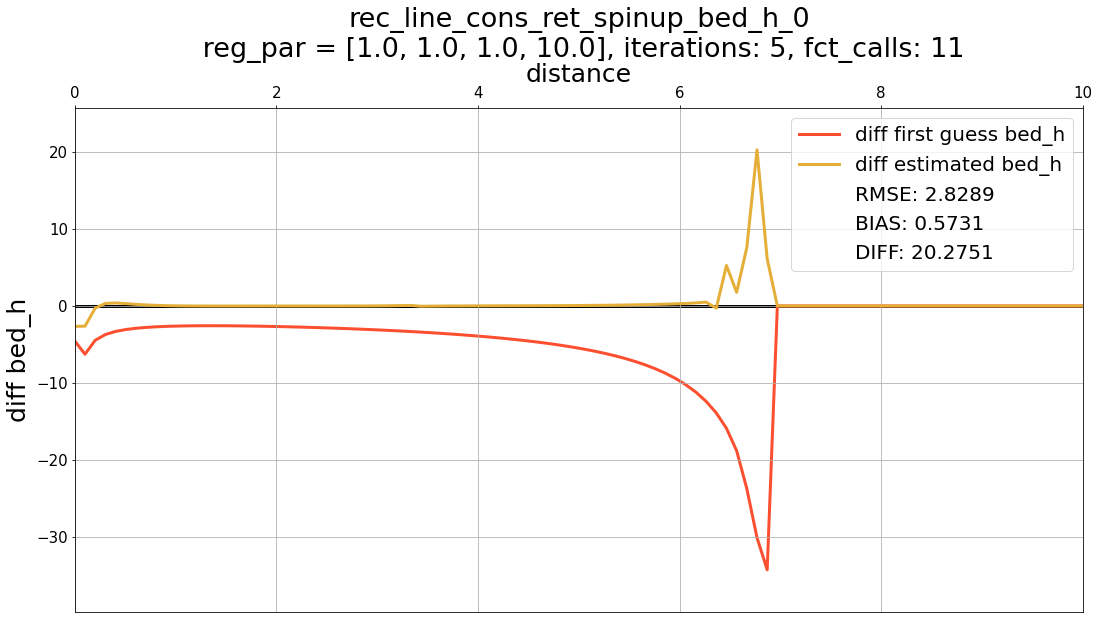

In [6]:
# plots
dl.save_result_plot()

or open the result file

In [7]:
result_dataset = xr.open_dataset("rec_line_cons_ret_spinup_bed_h.nc")
result_dataset

<xarray.Dataset>
Dimensions:                  (nr_of_iteration: 5, nr_of_reg_parameter: 4, one_dimension: 1, points_with_ice: 69, total_distance: 100)
Coordinates:
  * total_distance           (total_distance) float64 0.0 0.101 ... 9.899 10.0
  * points_with_ice          (points_with_ice) int64 0 1 2 3 4 ... 65 66 67 68
  * one_dimension            (one_dimension) int64 0
  * nr_of_iteration          (nr_of_iteration) int64 1 2 3 4 5
  * nr_of_reg_parameter      (nr_of_reg_parameter) int64 0 1 2 3
Data variables:
    spinup_sfc_h             (total_distance) float64 ...
    true_bed_h               (points_with_ice) float64 ...
    first_guessed_bed_h      (points_with_ice) float64 ...
    ice_mask                 (total_distance) bool ...
    true_surface_h           (total_distance) float64 ...
    first_guess_surface_h    (total_distance) float64 ...
    true_widths              (total_distance) float64 ...
    first_guess_widths       (total_distance) float64 ...
    total_true_bed_h         (total_distance) float64 ...
    true_spinup_ELA          (one_dimension) float64 ...
    true_spinup_sfc_h        (total_distance) float64 ...
    true_spinup_widths       (total_distance) float64 ...
    first_guess_spinup_ELA   (one_dimension) float64 ...
    guessed_bed_h            (nr_of_iteration, points_with_ice) float64 ...
    cost                     (nr_of_iteration) float64 ...
    cost_terms               (nr_of_iteration, nr_of_reg_parameter) float64 ...
    gradients_bed_h          (nr_of_iteration, points_with_ice) float64 ...
    function_calls           (nr_of_iteration) int64 ...
    optimisation_variable    (nr_of_iteration) object ...
    surface_h                (nr_of_iteration, total_distance) float64 ...
    widths                   (nr_of_iteration, total_distance) float64 ...
    computing_time           (nr_of_iteration) float64 ...
    current_main_iterations  (nr_of_iteration) float64 ...
    spinup_ELA_guessed       (nr_of_iteration) float64 ...
    spinup_ELA_grad          (nr_of_iteration) float64 ...
    spinup_sfc_h_guessed     (nr_of_iteration, total_distance) float64 ...
    spinup_widths_guessed    (nr_of_iteration, total_distance) float64 ...
Attributes:
    reg_parameters:                           [ 1.  1.  1. 10.]
    glacier_state:                            retreating with unknow spinup
    domain_points:                            100
    distance_between_points_m:                100
    years_of_model_run:                       40.0
    mb_ELA:                                   [3100. 3300.]
    mb_grad:                                  [4. 4.]
    geometry_of_bed_h:                        linear
    along_glacier_geometry:                   constant
    solver:                                   L-BFGS-B
    total_computing_time:                     64.31249642372131
    last minimisation messagebed_h:           b'STOP: TOTAL NO. of ITERATIONS...
    minimisation_possible:                    yes
    max_number_of_main_iteration(iterative):  1
    minimize_maxiter:                         5
    minimize_ftol:                            1e-07
    minimize_gtol:                            1e-08
    minimize_maxcor:                          50
    minimize_maxls:                           50
    maxiter_reached:                          yes